In [6]:
data_path = '/home/isabella/Documents/isabella/jake/ephys_analysis/processed_data'

pickle_to_load = 'df_all_cells_nexus.pkl'
output_pickle = 'df_all_place_cells.pkl'

calculate_significance = True
plot_rate_maps = True

############################
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from spelt.maps.rate_maps import plot_cluster_across_session, make_rate_maps_from_obj
from spelt.analysis.spatial_information import spatial_info
from spelt.analysis.spatial_significance import spatial_significance
from spelt.ephys_utils import gs_to_df

place_cells = 0
loaded_pickle = ''

# Load pickled data
if "df_all_cells" not in locals() and loaded_pickle != pickle_to_load:
    df_all_cells = pd.read_pickle(f'{data_path}/{pickle_to_load}')
    loaded_pickle = pickle_to_load
    # Drop rows with no included clusters
    df_all_cells = df_all_cells.dropna()
    print(f'{len(df_all_cells.index)} sessions retained')

class TrialData:
    def __init__(self, rate_maps, pos_map, max_rates, mean_rates, spike_times, age, trial_name):
        self.rate_maps = rate_maps
        self.pos_map = pos_map
        self.max_rates = max_rates
        self.mean_rates = mean_rates
        self.spike_times = spike_times
        self.age = age
        self.trial_name = trial_name
        self.bits_per_spike = None
        self.bits_per_sec = None
        self.p_values = {}
        self.z_scores = {}
        self.bps_shuffled = {}
        self.include = []

    def calculate_significance(self, pos_sample_times, pos_bin_idx, pos_sampling_rate, abs_threshold):
        """Calculates spatial significance."""
        # This method should update self.p_values and self.z_scores based on the significance calculations.
        for cluster in self.rate_maps.keys():
            self.p_values[cluster], self.z_scores[cluster], self.bps_shuffled[cluster] = spatial_significance(
                pos_sample_times, pos_bin_idx, pos_sampling_rate, self.spike_times[cluster], n_shuffles=1000
        )
            if self.p_values[cluster] < 0.05 and self.bits_per_spike[cluster] > abs_threshold:
                self.include.append(cluster)

trial_data_list = []

# Calculate rate maps
for session, obj in df_all_cells['ephys_object'].items():
    include = []
    bits_per_spike = {}
    p_values = {}

    # obj.load_pos(1)
    # # Set all position data < 200 to NaN
    # obj.pos_data[1]['xy_position'] = obj.pos_data[1]['xy_position'].where(obj.pos_data[1]['xy_position'] > 200)

    # Make rate maps for all trials
    rate_maps, pos_map, max_rates, mean_rates, spike_times, pos_bin_idx, pos_sample_times, pos_sampling_rate = make_rate_maps_from_obj(obj)

    for trial, trial_name in enumerate(obj.trial_list):
        
        # if trial != 1:
        #     continue

        # Save rate maps data to class
        trial_data = TrialData(rate_maps[trial], pos_map[trial], max_rates[trial], mean_rates[trial], spike_times[trial], obj.age, trial_name)

        # Calculate spatial information from rate and pos maps
        trial_data.bits_per_spike, trial_data.bits_per_sec = spatial_info(trial_data.rate_maps, trial_data.pos_map)
        bits_per_spike[trial] = trial_data.bits_per_spike

        if calculate_significance == True:
            if 'abs_threshold' in locals():
                abs_threshold = abs_threshold
            else:
                try:
                    abs_threshold = np.percentile(np.load(f'{data_path}/bits_per_spike_shuffled_all.npy'), 95)
                except:
                    print('No population shuffle data found. Setting abs_threshold to 0')
                    abs_threshold = 0
            
            # Calculate spatial significance for each trial for each cluster and populate trial_data.p_values, trial_data.z_scores and trial_data.bps_shuffled
            trial_data.calculate_significance(pos_sample_times[trial], pos_bin_idx[trial], pos_sampling_rate[trial], abs_threshold)
            p_values[trial] = trial_data.p_values

        trial_data_list.append(trial_data)

        include.append(trial_data.include)

    # Update df_all_cells with included unique clusters which have spatial significance on at least one trial
    include = np.unique(np.concatenate([np.array(i) for i in include]))
    df_all_cells.at[session, 'clusters_inc'] = include
    place_cells += len(include)

    ## RATE MAP PLOTTING
    if plot_rate_maps == True:
        # Define the directory where you want to save the figures
        save_directory = f'/home/isabella/Documents/isabella/jake/ephys_analysis/figures/P{obj.age}_{session}'
        
        # Check if the directory exists, if not, create it
        if not os.path.exists(save_directory):
            os.makedirs(save_directory)
        
        # Plot rate maps for all clusters in session
        for cluster in obj.spike_data['cluster_info'].index:
            cluster = int(cluster.split('_')[-1])
            plot_cluster_across_session(rate_maps_dict = rate_maps,
                                        cluster_id = cluster,
                                        max_rates_dict =  max_rates,
                                        mean_rates_dict = mean_rates,
                                        spatial_info_dict = bits_per_spike,
                                        spatial_significance_dict = p_values,
                                        session = session,
                                        age = obj.age)
            
            plt.tight_layout()
            plt.savefig(f'{save_directory}/{cluster}_rate_maps.png')
            plt.show()

Loading position data for 240320_r1503_sleep-ml_1
Position data already loaded for trial 1
Loading position data for 240320_r1503_open-field-sl_3


KeyError: 0

In [4]:
obj.pos_data


[None, None, None]

In [ ]:
obj.pos_data[1]['xy_position']

,13.694700,13.734700,13.774700,13.814700,13.854700,13.894733,13.934733,13.974733,14.014733,14.054767,...,745.332767,745.372767,745.412800,745.452767,745.492800,745.532800,745.572800,745.612800,745.652833,745.692833
X,249.734767,374.183482,374.109095,373.305038,373.345734,373.306020,373.746292,373.937169,373.944697,374.50384,...,362.415888,362.006566,361.336283,361.651194,361.441437,360.959763,360.19573,360.241735,360.184957,240.192922
Y,223.169291,334.785797,333.900467,332.938365,332.181931,331.806305,331.806498,331.818614,332.139893,331.97051,...,216.025805,216.256218,216.393290,216.916964,217.879850,218.932671,219.73853,219.891932,220.034635,146.942838


In [ ]:
## SAVE ALL DATA TO PICKLE FILES
# Initialise output structures
spatial_info_all = pd.DataFrame(columns = ['bits_per_spike', 'bits_per_sec', 'p_value', 'z_score' 'age'], dtype = 'object')
rates_all = pd.DataFrame(columns = ['mean_rates', 'max_rates', 'age'], dtype = 'object')
rate_maps_all = (pd.DataFrame(columns = all_trial_names, dtype = 'object')).astype('object')
pos_maps_all = (pd.DataFrame(columns = all_trial_names, dtype = 'object')).astype('object')
spike_times_all = (pd.DataFrame(columns = all_trial_names, dtype = 'object')).astype('object')
bits_per_spike_shuffled_all = np.array([])

def update_spatial_info(spatial_info_all, trial_data):
    for cluster in trial_data.rate_maps.keys():
        row = {
            'bits_per_spike': trial_data.bits_per_spike[cluster],
            'bits_per_sec': trial_data.bits_per_sec[cluster],
            'p_value': trial_data.p_values.get(cluster),
            'z_score': trial_data.z_scores.get(cluster),
            'age': trial_data.age
        }
        index = f'{trial_data.trial_name}_{cluster}'
        spatial_info_all.loc[index] = row

def update_rates_all(rates_all, trial_data):
    for cluster, max_rate in trial_data.max_rates.items():
        row = {
            'mean_rates': trial_data.mean_rates[cluster],
            'max_rates': max_rate,
            'age': trial_data.age
        }
        index = f'{trial_data.trial_name}_{cluster}'
        rates_all.loc[index] = row

def update_maps_and_times(rate_maps_all, pos_maps_all, spike_times_all, trial_data):
    trial_type = trial_data.trial_name.split("_")[-2] + "_" + trial_data.trial_name.split("_")[-1]
    for cluster in trial_data.rate_maps.keys():
        cluster_name = f'{trial_data.trial_name.split("_")[0]}_{trial_data.trial_name.split("_")[1]}_{cluster}'
        rate_maps_all.at[cluster_name, trial_type] = trial_data.rate_maps[cluster]
        pos_maps_all.at[cluster_name, trial_type] = trial_data.pos_map
        spike_times_all.at[cluster_name, trial_type] = trial_data.spike_times[cluster]
        rate_maps_all.at[cluster_name, 'age'] = trial_data.age
        pos_maps_all.at[cluster_name, 'age'] = trial_data.age
        spike_times_all.at[cluster_name, 'age'] = trial_data.age

def aggregate_bits_per_spike_shuffled(bits_per_spike_shuffled_all, trial_data_list):
    for trial_data in trial_data_list:
        if trial_data.bps_shuffled is not None:
            bits_per_spike_shuffled_all = np.append(bits_per_spike_shuffled_all, trial_data.bps_shuffled)
    return bits_per_spike_shuffled_all
for trial_data in trial_data_list:
    update_spatial_info(spatial_info_all, trial_data)
    update_rates_all(rates_all, trial_data)
    update_maps_and_times(rate_maps_all, pos_maps_all, spike_times_all, trial_data)

bits_per_spike_shuffled_all = aggregate_bits_per_spike_shuffled(bits_per_spike_shuffled_all, trial_data_list)

# # Define a dictionary mapping data to file paths
# data_to_path = {
#     'rate_maps_all': rate_maps_all,
#     'pos_maps_all': pos_maps_all,
#     'spatial_info_all': spatial_info_all,
#     'rates_all': rates_all,
#     'spike_times_all': spike_times_all,
#     }

# # Save data to pickle files
# for filename, data in data_to_path.items():
#     data.to_pickle(f'{data_path}/{filename}.pkl')

# # Resave df_all_cells with updated cluster inclusion
# df_all_cells.to_pickle(f'{data_path}/{output_pickle}')

# # Save all bits per spike shuffles
# np.save(f'{data_path}/bits_per_spike_shuffled_all.npy', bits_per_spike_shuffled_all)

# if calculate_significance:
#     print(f'{place_cells} cells with signifcant spatiality on at least one trial.') 

ValueError: Must have equal len keys and value when setting with an ndarray

In [ ]:
df

NameError: name 'df' is not defined

NameError: name 'abs_threshold' is not defined

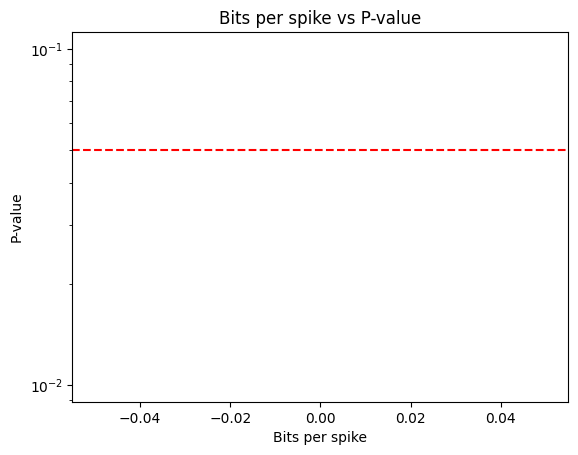

In [ ]:
spatial_info_all = pd.read_pickle('/home/isabella/Documents/isabella/jake/ephys_analysis/processed_data/spatial_info_all.pkl')

# Plot bits per spike against P-value
# Add small constant to avoid log(0)
spatial_info_all['p_value'] = spatial_info_all['p_value'] + 1e-3
plt.scatter(spatial_info_all['bits_per_spike'], spatial_info_all['p_value'], alpha = 0.2)
plt.xlabel('Bits per spike')
plt.ylabel('P-value')
plt.title('Bits per spike vs P-value')
plt.yscale('log')
plt.axhline(y = 0.05, color = 'r', linestyle = '--')
plt.axvline(x = abs_threshold, color = 'r', linestyle = '--')
plt.show()

In [ ]:
# from scipy.io import savemat

# rate_maps_open_field_1 = rate_maps_all.to_dict()['open-field_1']
# rate_maps_open_field_2 = rate_maps_all.to_dict()['open-field_2']
# rate_maps_t_maze_1 = rate_maps_all.to_dict()['t-maze_1']
# rate_maps_t_maze_2 = rate_maps_all.to_dict()['t-maze_2']
# occupancy_maps_open_field_1 = occupancy_maps_all.to_dict()['open-field_1']
# occupancy_maps_open_field_2 = occupancy_maps_all.to_dict()['open-field_2']
# occupancy_maps_t_maze_1 = occupancy_maps_all.to_dict()['t-maze_1']
# occupancy_maps_t_maze_2 = occupancy_maps_all.to_dict()['t-maze_2']

# maps_list = [rate_maps_open_field_1, rate_maps_open_field_2, rate_maps_t_maze_1, rate_maps_t_maze_2,
#              occupancy_maps_open_field_1, occupancy_maps_open_field_2, occupancy_maps_t_maze_1, occupancy_maps_t_maze_2]

# # add letter to each value in dict keys to make them valid matlab field names
# for m in maps_list[0:4]:
#     keys = list(m.keys())
#     for k in keys:
#         m['a' + k] = m.pop(k)
# for m in maps_list[4:8]:
#     keys = list(m.keys())
#     for k in keys:
#         m['b' + k] = m.pop(k)

# savemat('rate_maps_open-field_1.mat', maps_list[0])
# savemat('rate_maps_open-field_2.mat', maps_list[1])
# savemat('rate_maps_t-maze_1.mat', maps_list[2])
# savemat('rate_maps_t-maze_2.mat', maps_list[3])
# savemat('occupancy_maps_open-field_1.mat', maps_list[4])
# savemat('occupancy_maps_open-field_2.mat', maps_list[5])
# savemat('occupancy_maps_t-maze_1.mat', maps_list[6])
# savemat('occupancy_maps_t-maze_2.mat', maps_list[7])

In [ ]:
spatial_info_df =pd.read_pickle('/home/isabella/Documents/isabella/jake/ephys_analysis/processed_data/spatial_info_all.pkl')
spatial_info_df.dropna()


## Spatial Information & Stats

In [ ]:
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Set age bins
age_bins = [(22, 26), (27, 29), (30, 35)]

# Load pickled rate map data
rate_maps_all = pd.read_pickle('/home/isabella/Documents/isabella/jake/ephys_analysis/processed_data/rate_maps_all.pkl')
spatial_info_df = pd.read_pickle('/home/isabella/Documents/isabella/jake/ephys_analysis/processed_data/spatial_info_all.pkl')

# Format spatial info dataframe
# spatial_info_df.dropna(inplace = True)
spatial_info_df.reset_index(inplace = True)
spatial_info_df = spatial_info_df.rename(columns = {'index': 'cell_id'})
spatial_info_df['trial_type'] = spatial_info_df['cell_id'].apply(lambda x: x.split('_')[-3])
spatial_info_df['age'] = spatial_info_df['age'].astype(int)

# Select only cells with p < 0.05 and spatial info > abs_threshold
spatial_info_df = spatial_info_df[spatial_info_df['p_value'] < 0.05]
spatial_info_df = spatial_info_df[spatial_info_df['bits_per_spike'] > abs_threshold]
# Make mask for significant cells
significant_cells = spatial_info_df['cell_id']

# Group by age bin
spatial_info_df['age_bin'] = pd.cut(spatial_info_df['age'], bins = [22, 26, 29, 35], labels = ['22-26', '27-29', '30-35'])
# Convert 'age_bin' column to categorical data type
spatial_info_df['age_bin'] = pd.Categorical(spatial_info_df['age_bin'], categories=['22-26', '27-29', '30-35'], ordered=True)

# Calculate mean and std of bits_per_spike and bits_per_sec
spatial_info_df_stats = spatial_info_df.groupby('age_bin').agg({'bits_per_spike': ['mean', 'std'], 'bits_per_sec': ['mean', 'std']}).reset_index()

# Perform ANOVA on age bin and bits per spike
anova_bits_per_spike = stats.f_oneway(spatial_info_df[spatial_info_df['age_bin'] == '22-26']['bits_per_spike'],
                       spatial_info_df[spatial_info_df['age_bin'] == '27-29']['bits_per_spike'],
                       spatial_info_df[spatial_info_df['age_bin'] == '30-35']['bits_per_spike'])
print(f'ANOVA for bits per spike: {anova_bits_per_spike}')

# Perform ANOVA on age bin and bits per sec
anova_bits_per_sec = stats.f_oneway(spatial_info_df[spatial_info_df['age_bin'] == '22-26']['bits_per_sec'],
                       spatial_info_df[spatial_info_df['age_bin'] == '27-29']['bits_per_sec'],
                       spatial_info_df[spatial_info_df['age_bin'] == '30-35']['bits_per_sec'])
print(f'ANOVA for bits per sec: {anova_bits_per_sec}')

# Replace string age bins with integers
age_bin_mapping = {'22-26': 1, '27-29': 2, '30-35': 3}
spatial_info_df['age_bin'] = spatial_info_df['age_bin'].replace(age_bin_mapping)

if anova_bits_per_spike[1] < 0.05:
    # Perform Tukey HSD test for bits per spike
    tukey_bits_per_spike = pairwise_tukeyhsd(spatial_info_df['bits_per_spike'].astype(float), spatial_info_df['age_bin'])
    print(f'Tukey HSD for bits per spike: {tukey_bits_per_spike}')
else:
    print('ANOVA for bits per spike not significant, skipping Tukey HSD test')

# if p < 0.05, perform Tukey HSD test
if anova_bits_per_sec[1] < 0.05:
    # Perform Tukey HSD test for bits per sec
    tukey_bits_per_sec = pairwise_tukeyhsd(spatial_info_df['bits_per_sec'].astype(float), spatial_info_df['age_bin'])
    print(f'Tukey HSD for bits per sec: {tukey_bits_per_sec}')
else:
    print('ANOVA for bits per sec not significant, skipping Tukey HSD test')

# Plot bits_per_spike and bits_per_sec for each age bin
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
axes[0].errorbar(x = spatial_info_df_stats['age_bin'], y = spatial_info_df_stats['bits_per_spike']['mean'], yerr = spatial_info_df_stats['bits_per_spike']['std'], fmt = 'o')
axes[0].set_title('Bits per spike')
axes[0].set_xlabel('Age bin')
axes[0].set_ylabel('Bits per spike')
axes[0].set_ylim(0, 1.5)

axes[1].errorbar(x = spatial_info_df_stats['age_bin'], y = spatial_info_df_stats['bits_per_sec']['mean'], yerr = spatial_info_df_stats['bits_per_sec']['std'], fmt = 'o')
axes[1].set_title('Bits per second')
axes[1].set_xlabel('Age bin')
axes[1].set_ylabel('Bits per second')
axes[1].set_ylim(0, 3)


## Spatial Correlation & Stats

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from spatial_correlation import spatial_correlation
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

age_bins = [(22, 26), (27, 29), (30, 35)]

# Load pickled rate map data
rate_maps_all = pd.read_pickle('/home/isabella/Documents/isabella/jake/ephys_analysis/processed_data/rate_maps_all.pkl')

# # Drop non-significant cells using mask
significant_sessions = significant_cells.apply(lambda x: x.split('_')[0] + '_' + x.split('_')[1] + '_' + x.split('_')[5]).unique()
rate_maps_all = rate_maps_all[rate_maps_all.index.isin(significant_sessions)]
# # Drop all rate map indices containing r1364
# rate_maps_all = rate_maps_all[rate_maps_all.index.str.contains('r1432')]

# Calculate spatial correlation for each cluster across both trial types
for trial_type in ['open-field', 't-maze']:
    rate_maps_correlation = rate_maps_all[[f'{trial_type}_1', f'{trial_type}_2']].dropna()

    spatial_correlations = spatial_correlation(rate_maps_correlation[f'{trial_type}_1'].to_list(), rate_maps_correlation[f'{trial_type}_2'].to_list())

    rate_maps_all.loc[rate_maps_correlation.index, f'spatial_correlation_{trial_type}'] = spatial_correlations

rate_maps_all

# Keep only age and spatial correlation columns
spatial_correlations = rate_maps_all[['age', 'spatial_correlation_open-field', 'spatial_correlation_t-maze']].dropna().copy()
# Convert age to int
spatial_correlations['age'] = spatial_correlations['age'].astype(int)

# Group by age bin
spatial_correlations['age_bin'] = pd.cut(spatial_correlations['age'], bins = [22, 26, 29, 35], labels = ['22-26', '27-29', '30-35'])
# Convert 'age_bin' column to categorical data type
spatial_correlations['age_bin'] = pd.Categorical(spatial_correlations['age_bin'], categories=['22-26', '27-29', '30-35'], ordered=True)

# Calculate mean and std of spatial info correlations
spatial_correlations_stats = spatial_correlations.groupby('age_bin').agg({'spatial_correlation_open-field': ['mean', 'std'], 'spatial_correlation_t-maze': ['mean', 'std']}).reset_index()

# Perform ANOVA on age bin and open field spatial correlation
anova_open_field = stats.f_oneway(spatial_correlations[spatial_correlations['age_bin'] == '22-26']['spatial_correlation_open-field'],
                       spatial_correlations[spatial_correlations['age_bin'] == '27-29']['spatial_correlation_open-field'],
                       spatial_correlations[spatial_correlations['age_bin'] == '30-35']['spatial_correlation_open-field'])
print(f'ANOVA for spatial_correlation_open-field: {anova_open_field}')

# Perform ANOVA on age bin and t-maze spatial correlation
anova_tmaze = stats.f_oneway(spatial_correlations[spatial_correlations['age_bin'] == '22-26']['spatial_correlation_t-maze'],
                       spatial_correlations[spatial_correlations['age_bin'] == '27-29']['spatial_correlation_t-maze'],
                       spatial_correlations[spatial_correlations['age_bin'] == '30-35']['spatial_correlation_t-maze'])
print(f'ANOVA for spatial_correlation_t-maze: {anova_tmaze}')

# Replace string age bins with integers
age_bin_mapping = {'22-26': 1, '27-29': 2, '30-35': 3}
spatial_correlations['age_bin'] = spatial_correlations['age_bin'].replace(age_bin_mapping)

# if p < 0.05, perform Tukey HSD test
if anova_open_field[1] < 0.05:
    print('ANOVA significant, performing Tukey HSD test')
    # Perform Tukey HSD test for open field spatial correlation
    tukey_open_field = pairwise_tukeyhsd(spatial_correlations['spatial_correlation_open-field'], spatial_correlations['age_bin'])
    print(f'Tukey HSD for spatial_correlation_open-field: {tukey_open_field}')
else:
    print('ANOVA for open field not significant, skipping Tukey HSD test')

if anova_tmaze[1] < 0.05:
    # Perform Tukey HSD test for t-maze spatial correlation
    tukey_tmaze = pairwise_tukeyhsd(spatial_correlations['spatial_correlation_t-maze'], spatial_correlations['age_bin'])
    print(f'Tukey HSD for bits spatial_correlation_t-maze: {tukey_tmaze}')
else:
    print('ANOVA for T-maze not significant, skipping Tukey HSD test')

# Plot spatial correlation for open field and t-maze for each age bin
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
axes[0].errorbar(x = spatial_correlations_stats['age_bin'], y = spatial_correlations_stats['spatial_correlation_open-field']['mean'], yerr = spatial_correlations_stats['spatial_correlation_open-field']['std'], fmt = 'o')
axes[0].set_title('Spatial Correlation Open Field')
axes[0].set_xlabel('Age bin')
axes[0].set_ylim(0, 1)
axes[0].set_ylabel('Spatial Correlation')

axes[1].errorbar(x = spatial_correlations_stats['age_bin'], y = spatial_correlations_stats['spatial_correlation_t-maze']['mean'], yerr = spatial_correlations_stats['spatial_correlation_t-maze']['std'], fmt = 'o')
axes[1].set_title('Spatial Correlation T-Maze')
axes[1].set_xlabel('Age bin')
axes[1].set_ylabel('Spatial Correlation')
axes[1].set_ylim(0, 1)

In [ ]:
from session_utils import find_all_sessions
from ephys import *
import matplotlib.pyplot as plt

# Load all cells from phy with age
# Find all included sessions from Google sheet, with structure session_name: path
session_dict = find_all_sessions(sheet_path = 'https://docs.google.com/spreadsheets/d/1_Xs5i-rHNTywV-WuQ8-TZliSjTxQCCqGWOD2AL_LIq0/edit#gid=0',
                                 data_path = '/home/isabella/Documents/isabella/jake/recording_data',
                                 sorting_suffix = 'sorting_ks2_custom')
print(f'{len(session_dict.items())} sessions found')

cluster_info_all = pd.DataFrame()

for session, session_path in session_dict.items():
    
    # Create ephys object
    obj = ephys(recording_type = 'nexus', path = session_path)
    
    ## A. Load good cells from phy
    obj.load_spikes('good')
    
    # Get cluster info from phy
    cluster_info = obj.spike_data['cluster_info']

    cluster_info['session'] = session
    
    # Append session to cluster_info_all index
    cluster_info.index = cluster_info['session'] + '_' + cluster_info.index.astype(str)

    # Add age to cluster_info
    cluster_info['age'] = obj.age
    
    # Concat cluster info for all sessions
    cluster_info_all = pd.concat([cluster_info_all, cluster_info])

cluster_info_all

# Load all pyramidal cells
pyramidal_cells_df = pd.read_pickle('/home/isabella/Documents/isabella/jake/ephys_analysis/processed_data/df_all_cells.pkl')
pyramidal_cells_df.dropna(inplace = True)

# Loop through rows and make a list of all included clusters
pyramidal_cells = []
for session, clusters in pyramidal_cells_df['clusters_inc'].items():
    try:
        for cluster in clusters:
            pyramidal_cells.append(f'{session}_{cluster}')
    except:
        pyramidal_cells.append(f'{session}_{clusters}')


# Load all place cells
place_cells_df = pd.read_pickle('/home/isabella/Documents/isabella/jake/ephys_analysis/processed_data/df_all_place_cells.pkl')
place_cells_df.dropna(inplace = True)

# Loop through rows and make a list of all included clusters
place_cells = []
for session, clusters in place_cells_df['clusters_inc'].items():
    try:
        for cluster in clusters:
            place_cells.append(f'{session}_{cluster}')
    except:
        place_cells.append(f'{session}_{clusters}')


# Make a boolean column in cluster_info_all for each cell type
cluster_info_all['pyramidal'] = cluster_info_all.index.isin(pyramidal_cells)
cluster_info_all['place_cell'] = cluster_info_all.index.isin(place_cells)
# Add column which is true for all cells
cluster_info_all['cell'] = True

cluster_info_all

In [ ]:
# Plot a stacked bar chart of all, pyramidal and place cells by age with one bar per day
# Group by age and count number of cells
cell_counts = cluster_info_all.groupby('age').agg({'cell': 'sum', 'pyramidal': 'sum', 'place_cell': 'sum'}).reset_index()

# Plot
fig, ax = plt.subplots(figsize = (10, 5))
ax.bar(cell_counts['age'], cell_counts['cell'], label = 'Non-included cells')
ax.bar(cell_counts['age'], cell_counts['pyramidal'], label = 'Non-place CA1 pyramidal cells')
ax.bar(cell_counts['age'], cell_counts['place_cell'], label = 'Place cells')
ax.set_xlabel('Age')
ax.set_ylabel('Number of cells')
ax.set_title('Number of cells by age')
ax.legend()
plt.show()